# Spatial correlations

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import numpy as np
import pandas as pd
import re
import xarray as xr

In [2]:
## Reading values from the significance test output file
ews_recent = pd.read_csv('output/pvalues_coords_since_1920.csv',index_col=0)
## Reading metadata from records with recent data
md_recent = pd.read_csv('output/sel_recent_rec_metadata.csv',index_col=0)
## Reading labels
rec_labels = pd.read_csv('output/sel_rec_labels.csv',index_col=0)
ews_recent = ews_recent[ews_recent.index.isin(md_recent.index)]

### Correlations with the Subpolar gyre region
sp_corr_path = 'output/spatial_correlations/'
corrs_spg = pd.read_csv('output/corrs_biv_en4temp_spg.csv',index_col=0)
ews_recent = pd.concat([corrs_spg.loc[ews_recent.index],ews_recent],axis=1)
ews_recent['abscorr_spg_detr'] = ews_recent['r_detr'].abs()

In [3]:
lons = [-65,30]
lats = [44,75]
proj = ccrs.TransverseMercator(central_longitude=lons[0]+(lons[1]-lons[0])/2,
                                   central_latitude=lats[0]+(lats[1]-lats[0])/2)
n = 20
aoi = mpath.Path(
    list(zip(np.linspace(lons[0],lons[1], n), np.full(n, lats[1]))) + \
    list(zip(np.full(n, lons[-1]), np.linspace(lats[1], lats[0], n))) + \
    list(zip(np.linspace(lons[1], lons[0], n), np.full(n, lats[0]))) + \
    list(zip(np.full(n, lons[0]), np.linspace(lats[0], lats[1], n)))
)

In [4]:
formatted_labels = {'TP_DR_NEars': 'Tiree\nPassage',
 'FG_PB_A_LCars': 'Fladen\nGround A',
 'FG_PB_B_LCars': 'Fladen\nGround B',
 'FG_PB_C_LCars': 'Fladen\nGround C',
 'FG_PB_F1_LCars': 'Fladen\nGround F1',
 'FG_PB_F5_LCars': 'Fladen\nGround F5',
 'IOME_WB_NEars': 'Isle of Man (East)',
 'Faroe_FWB_NEars': 'Faroe\nShelf',
 'Norw_HH_RCS': 'Southern\nNorwegian S.',
 'DB_HH_RCS': 'Doggerbank',
 'ENS_HH_RCS': 'Eastern North\nSea',
 'BL_IR': 'Belfast\nLough',
 'EC_SH': 'English\nChannel',
 'BS_MM_NE': 'Northern\nNorway',
 'BS_MM_d18O': 'Northern Norway\n$\\delta ^{18}O$',
 'FG_JEM_PAD': 'Fladen\nGround',
 'FG_JEM_d13C': 'Fladen\nGround $\\delta ^{13}C$',
 'NIS_DR_d18O': 'North Icelandic\nShelf $\\delta ^{18}O$',
 'NIS_DR_d13C': 'North Icelandic\nShelf $\\delta ^{13}C$',
 'TP_DR_d18O': 'Tiree Passage\n$\\delta ^{18}O$',
 'TP_DR_d13C': 'Tiree Passage\n$\\delta ^{13}C$',
 'SPNF_PP_GD': 'Newfoundland\nShelf A',
 'SPNF_deep_PP_NE': 'Newfoundland\nShelf B',
 'SNS_BS_Td18O': 'Amrumbank',
 'IS_PB_NEars': 'Isle of\nMan',
 'NIS_PB_NEars': 'North Icelandic\nShelf',
 'CNS_BS_LGFraw': 'Central North\nSea',
 'SWI_MM_d18O': 'Southwest\nIceland $\\delta ^{18}O$',
 'SWI_MM_HGF': 'Southwest\nIceland',
 'VB_TT_NEars': 'Viking Bank',
 'VB_TT_d18O': 'Viking Bank \n$\\delta ^{18}O$'}

In [5]:
int_corrs_to_plot = ews_recent.sort_values(by=['ar1'],ascending=False)

In [6]:
sig_trend_rec = ews_recent[ews_recent.perc_signif>=0.2].sort_values(by='abscorr_spg_detr',ascending=False).index.values
oxy_rec = [r for r in ews_recent[ews_recent.perc_positive>0.75].index if 'd18O' in r]
robust_rec = ews_recent[ews_recent['median'].round(1)>=0].sort_values(by='abscorr_spg_detr',ascending=False).index.values
mod_rob_rec = [r for r in robust_rec if r not in sig_trend_rec]
non_robust_rec = ews_recent[ews_recent['median'].round(1)<0]
non_robust_rec = non_robust_rec.sort_values(by='abscorr_spg_detr',ascending=False).index.values

In [7]:
def get_new_coors_proj(grouped_coors_row,coords_df,proj, radius=1.5,init_angle=-20,trim_angle=10,full_angle=220):
    """
    Estimates the new coordinates for a group of records with the same coordinates
    Returns the new coordinates in the coordinate system of the received projection
    """
    res_ang = full_angle - (2 * trim_angle) # 
    n_rec = grouped_coors_row['count'] 
    part_angle = res_ang/(n_rec + 1) # Resulting angle after dividing by the number of records
    group_df = coords_df.loc[grouped_coors_row['record']] ## Retrieving dataframe
    proj_cart = ccrs.PlateCarree() ## Cartesian coordinate system
    x,y = proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean(),src_crs=proj_cart)
    ## One degree of latitude in the projection coordinates
    one_deg_lat_proj = y - proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean()+1,src_crs=proj_cart)[1]
    group_df['x'] = x
    group_df['y'] = y
    y_plus = []
    x_plus = []    
    
    for i in range(1,n_rec+1):        
        y_plus.append(np.sin(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
        x_plus.append(np.cos(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
    group_df.y += y_plus
    group_df.x += x_plus
    return group_df

In [8]:
def plot_spatial_corrs(bW=35,lag=0,col_corr_spg = 'r_detr'):
    """
    Plots spatial correlations for each one of the bivalve records
    """
    lagstr = '' if lag == 0 else f'_lag{lag}'
    recs_order = list(sig_trend_rec) + list(mod_rob_rec) + list(non_robust_rec)
    columns = 3
    rows = int(np.ceil(len(int_corrs_to_plot)/columns))
    markers = {'growth':'o','oxygen':'^','carbon':'d'}
    markersize = {'growth':65,'oxygen':75,'carbon':75}

    fig = plt.figure(figsize=(2.9*columns,1.7*rows),facecolor='white')

    mpl.rcParams['hatch.linewidth'] = 0.3
    axs = []
    for i,rec_id in enumerate(recs_order):
        ax = fig.add_subplot(rows, columns, i+1, projection=proj)
        axs.append(ax)
        ax.set_boundary(aoi, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND,zorder=2)
        ax.coastlines(resolution='50m',zorder=2)
        gl = ax.gridlines(draw_labels=True,linewidth=0.00001, linestyle='--',alpha=0)
        ax.set_extent([lons[0], lons[1], lats[0], lats[1]])
        gl.top_labels = False
        gl.right_labels = False
        if i%columns != 0:
            gl.left_labels = False
        if i < len(int_corrs_to_plot)-3:
            gl.bottom_labels = False
        ### Reaging file
        if bW==0:
            sp_corr = xr.open_mfdataset(sp_corr_path+'EN4_'+rec_id+f'{lagstr}_nodetr_1960.nc')
        else:
            sp_corr = xr.open_mfdataset(sp_corr_path+'EN4_'+rec_id+f'{lagstr}_{bW}_bW_1960.nc')
        sp_corr_map = sp_corr.pearson_r.plot(ax=ax,transform=ccrs.PlateCarree(),
                                               vmin=-0.65,vmax=0.65,cmap='bwr',add_colorbar=False, rasterized=True)

        levels = np.linspace(sp_corr.where(sp_corr.p_value<0.05).pearson_r.min(), sp_corr.where(sp_corr.p_value<0.05).pearson_r.max(),16)
        ax.contourf(sp_corr.lon, sp_corr.lat, sp_corr.where(sp_corr.p_value<0.05).pearson_r,levels=levels, transform=ccrs.PlateCarree(),
                       colors='none',hatches=['','...'],alpha=0)

        rec_info = ews_recent.loc[rec_id]

        ax.scatter(x=rec_info.Longitude, y=rec_info.Latitude, s=markersize[rec_info.type],
                   marker=markers[rec_info.type],linewidth=1.5,c=rec_info[col_corr_spg],edgecolors='k',               
                   vmin=-0.65,vmax=0.65,cmap='bwr',transform=ccrs.PlateCarree(),zorder=2)
        title = formatted_labels[rec_id]
        ax.set_title(title,fontsize=9)
    cbar = plt.colorbar(sp_corr_map, ax=axs,shrink=0.6,aspect=30,extend='both')
    cbar.ax.set_ylabel(r'Pearson $r$', fontsize=10);
    #fig.tight_layout()
    fig.savefig(f'img/EN4_ind_sp_corr_bW{bW}_lag{lag}.png',dpi=500, bbox_inches='tight')

In [9]:
def integrate_spatial_corrs(bW=35,lag=0):
    lagstr = '' if lag == 0 else f'lag{lag}_'
    comparison = {'sigt':sig_trend_rec,'oxy':oxy_rec,'moder_rob':mod_rob_rec,'non_robust':non_robust_rec}
    int_corrs = {}
    ds = 'EN4'
#for ds in ['EN4']:
    if bW==0:
        model_array = xr.open_mfdataset(sp_corr_path+ds+f'_IS_PB_NEars_nodetr_1960.nc').load() 
    else:
        model_array = xr.open_mfdataset(sp_corr_path+ds+f'_IS_PB_NEars_{lagstr}{bW}_bW_1960.nc').load() 
    for comp,ind in comparison.items():
        sum_signif = xr.zeros_like(model_array)
        sum_signif = sum_signif.rename_vars({'pearson_r':'num_rec'})
        sum_signif = sum_signif.drop_vars(['p_value'])
        avg_corr = xr.zeros_like(model_array)
        avg_corr = avg_corr.rename_vars({'pearson_r':'avg_corr'})
        avg_corr = avg_corr.drop_vars(['p_value'])
        if bW==0:
            sp_corr_files = [ds+'_'+r+f'_nodetr_1960.nc' for r in ind]
        else:
            sp_corr_files = [ds+'_'+r+f'_{lagstr}{bW}_bW_1960.nc' for r in ind]
        for chron_id in sp_corr_files:
            sp_corr = xr.open_mfdataset(sp_corr_path+chron_id)
            avg_corr = avg_corr + sp_corr.apply(np.fabs).pearson_r            
            temp = xr.ones_like(sum_signif)
            temp = temp.where(sp_corr.p_value<0.05,0)
            sum_signif = sum_signif + temp
            #del temp
        avg_corr = avg_corr/len(ind) ## Average absolute correlation
        avg_corr = avg_corr.where(model_array.p_value.notnull())
        prop_sig = sum_signif/len(ind) ## Proportion of records with a significant correlation
        prop_sig = prop_sig.where(model_array.p_value.notnull())
        int_corrs[ds+'_'+comp+'_propsig'] = prop_sig
        int_corrs[ds+'_'+comp+'_nsig'] = sum_signif
        int_corrs[ds+'_'+comp+'_avgcorr'] = avg_corr
        del sum_signif,prop_sig, avg_corr
    return int_corrs

In [10]:
def plot_integrated_spatial_corrs(int_corrs,bW=35,lag=0):
    """
    Plots the averaged spatial correlations
    """
    lons = [-65,30]
    lats = [44,75]
    proj = ccrs.TransverseMercator(central_longitude=lons[0]+(lons[1]-lons[0])/2,
                                       central_latitude=lats[0]+(lats[1]-lats[0])/2)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(lons[0],lons[1], n), np.full(n, lats[1]))) + \
        list(zip(np.full(n, lons[-1]), np.linspace(lats[1], lats[0], n))) + \
        list(zip(np.linspace(lons[1], lons[0], n), np.full(n, lats[0]))) + \
        list(zip(np.full(n, lons[0]), np.linspace(lats[0], lats[1], n)))
    )

    fig = plt.figure(figsize=(14,9),facecolor='white')
    ax1 = fig.add_subplot(1, 3, 1, projection=proj)
    ax2 = fig.add_subplot(1, 3, 2, projection=proj)
    ax3 = fig.add_subplot(1, 3, 3, projection=proj)
    for ax in [ax1,ax2,ax3]:
        ax.set_boundary(aoi, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND,zorder=2)
        ax.coastlines(resolution='50m',zorder=2)
        gl = ax.gridlines(draw_labels=True,linewidth=0.000001, linestyle='--',alpha=0)
        ax.set_extent([lons[0], lons[1], lats[0], lats[1]])
        gl.top_labels = False
        gl.right_labels = False

    for i,(sr_map,ax) in enumerate(zip(['EN4_sigt','EN4_moder_rob','EN4_non_robust'],[ax1,ax2,ax3])):
            map_avg = int_corrs[sr_map+'_avgcorr'].avg_corr.plot(ax=ax,transform=ccrs.PlateCarree(),
                                               vmin=0,vmax=0.35,cmap='viridis',add_colorbar=False,rasterized=True)
            ps = int_corrs[sr_map+'_propsig']

            mpl.rcParams['hatch.linewidth'] = 0.3
            ax.contourf(ps.lon, ps.lat, ps.where(ps.num_rec>=0.5).num_rec, transform=ccrs.PlateCarree(),
                       colors='none',hatches=['....'],alpha=0)
            map_avg.set_edgecolor('face')
    cbar_avg = plt.colorbar(map_avg, ax=[ax1,ax2,ax3],shrink=0.38,orientation='horizontal',pad=0.19,extend='max')
    cbar_avg.ax.set_xlabel(r'Average absolute Pearson $r$', fontsize=10);

    #### Plotting the bivalve records
    ### Grouping coordinates
    for i,(rec_ids,ax) in enumerate(zip([sig_trend_rec,mod_rob_rec,non_robust_rec],[ax1,ax2,ax3])):
        biv_ews = ews_recent.loc[rec_ids]
        coors_yr_df = biv_ews.reset_index()
        coors_yr_df.rename(columns={'index':'record'}, inplace=True)
        coors_yr_gr = coors_yr_df.groupby([coors_yr_df['Latitude'].apply(lambda x: round(x*2)/2),coors_yr_df['Longitude'].apply(lambda x: round(x*2)/2)]).agg(list)
        coors_yr_gr['count'] = coors_yr_gr.record.apply(lambda x: len(x))
        unique_yr_coors = coors_yr_gr[coors_yr_gr['count']==1].record.apply(lambda x: x[0]).values
        yr_unique_coors = biv_ews.loc[unique_yr_coors]    
        markers = {'growth':'o','oxygen':'^','carbon':'d'}
        markersize = {'growth':50,'oxygen':50,'carbon':53}
        indicator = 'kc'
        ## Records with repeated coordinates
        initial_angles = {(56.5, -6.5):-90,(59.0, 0.5):0,(59.5, 0.5):90,(66.5, -18.0):140,(71.0, 24.0):-135,(47.0, -56.5):50}
        full_angles = {(56.5, -6.5):170,(59.0, 0.5):110,(59.5, 0.5):110,(66.5, -18.0):260,(71.0, 24.0):260,(47.0, -56.5):150}
        radii = {(56.5, -6.5):5,(59.0, 0.5):3,(59.5, 0.5):3,(66.5, -18.0):3,(71.0, 24.0):5.5,(47.0, -56.5):2.5}
        origin_radii = {(56.5, -6.5):0,(59.0, 0.5):0.8,(59.5, 0.5):0.7,(66.5, -18.0):0,(71.0, 24.0):0,(47.0, -56.5):0}
        ## Parameters for isotope records
        plus_radii = {(56.5, -6.5):3,(59.0, 0.5):2,(59.5, 0.5):2,(66.5, -18.0):2.5,(71.0, 24.0):2.5,(47.0, -56.5):1}
        plus_initangle = {(56.5, -6.5):0,(59.0, 0.5):-30,(59.5, 0.5):-30,(66.5, -18.0):-10,(71.0, 24.0):-7,(47.0, -56.5):0}

        selected_gr = coors_yr_gr[coors_yr_gr['count']>1]
        for idx,row in selected_gr.iterrows():
            if i == 1 and idx in [(71.0, 24.0),(56.5,-6.5)]:
                f_rad = 0.65
            else:
                f_rad = 1
            new_coors = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]*f_rad,init_angle=initial_angles[idx],full_angle=full_angles[idx])

            for type_rec,marker in markers.items():
                coors_type = new_coors[new_coors.type==type_rec]
                if len(coors_type) > 0:
                    ax.scatter(x=coors_type.x, y=coors_type.y, s=markersize[type_rec],linewidth=1.3, marker=marker,
                           color='red', edgecolors='k',zorder=2)
           ## Lines
            new_coors_lines = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]*f_rad-1.5,init_angle=initial_angles[idx],full_angle=full_angles[idx])
            new_coors_origin = get_new_coors_proj(row,biv_ews,proj,radius=origin_radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])        
            ax.plot([new_coors_lines.x, new_coors_origin.x], [new_coors_lines.y, new_coors_origin.y],color='k')
        ## Records with unique coordinates
        for type_rec,marker in markers.items():            
            coors_type = yr_unique_coors[yr_unique_coors.type==type_rec]
            coors_type = coors_type.sort_values(by='ar1')
            if len(coors_type) > 0:
                ax.scatter(x=coors_type.Longitude, y=coors_type.Latitude, s=markersize[type_rec],marker=marker,
                           linewidth=1.3,color='red',transform=ccrs.PlateCarree(),
                           edgecolors='k',zorder=2)
    ax1.text(x=-0.1,y=1.04,s='A',transform=ax1.transAxes,fontsize=14,fontweight='bold')
    ax2.text(x=-0.1,y=1.04,s='B',transform=ax2.transAxes,fontsize=14,fontweight='bold');
    ax3.text(x=-0.1,y=1.04,s='C',transform=ax3.transAxes,fontsize=14,fontweight='bold');
    fig.savefig(f'img/EN4_avg_corr_sigt_mod_weak_bW{bW}_lag{lag}.pdf',dpi=350, bbox_inches='tight')

## Correlations with no lag (bW= 35)

In [11]:
plt.close()
plot_spatial_corrs(bW=35,lag=0,col_corr_spg = 'r_detr')

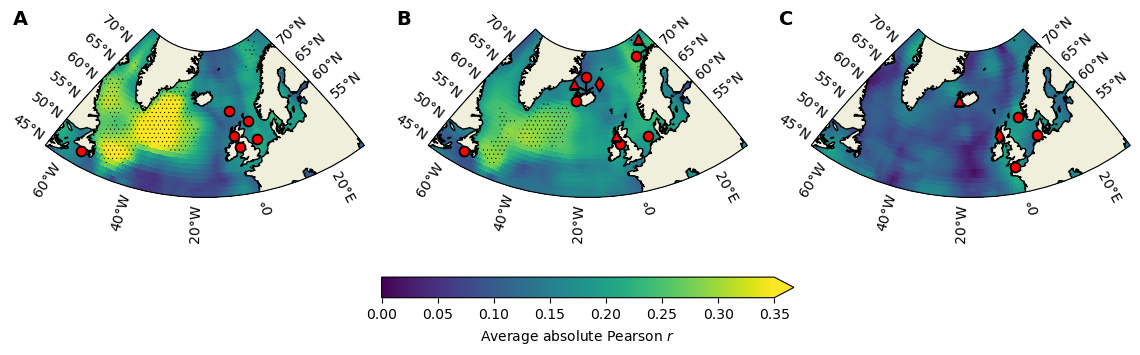

In [12]:
int_corrs_bW35_lag0 = integrate_spatial_corrs(bW=35,lag=0)
plt.close()
plot_integrated_spatial_corrs(int_corrs_bW35_lag0,bW=35,lag=0)
plt.show()

### Records from Figure 1

In [13]:
recs_multid_pattern = ['IS_PB_NEars','TP_DR_NEars','FG_JEM_PAD','SPNF_PP_GD','Faroe_FWB_NEars',
                       'BS_MM_d18O',
                       'FG_PB_B_LCars', 'FG_PB_C_LCars','FG_PB_F5_LCars',
                       'Norw_HH_RCS','NIS_DR_d18O','NIS_PB_NEars']

md_selected_rec = pd.read_csv('output/sel_records_metadata.csv',index_col=0)

In [14]:
def rec_type(row):
    if '18O' in row.name:
        return 'oxygen'
    elif '13C' in row.name:
        return 'carbon'
    else:
        return 'growth'

In [15]:
coords = pd.DataFrame(index=md_selected_rec.index)
coords['Latitude'] = (md_selected_rec['Northernmost_lat']+md_selected_rec['Southernmost_lat'])/2
coords['Longitude'] = (md_selected_rec['Westernmost_lon']+md_selected_rec['Easternmost_lon'])/2
coords['type'] = coords.apply(lambda x: rec_type(x),axis=1)

In [16]:
### Integrating the information
avg_1920_ts_corrs = {}
ds = 'EN4'
model_array = xr.open_mfdataset(sp_corr_path+ds+'_IS_PB_NEars_35_bW_1960.nc').load() 
avg_corr = xr.zeros_like(model_array)
avg_corr = avg_corr.rename_vars({'pearson_r':'avg_corr'})
avg_corr = avg_corr.drop_vars(['p_value'])   
sp_corr_files = [ds+'_'+r+'_35_bW_1960.nc' for r in recs_multid_pattern]
sum_signif = xr.zeros_like(model_array)
sum_signif = sum_signif.rename_vars({'pearson_r':'num_rec'})
sum_signif = sum_signif.drop_vars(['p_value'])

for chron_id in sp_corr_files:
    sp_corr = xr.open_mfdataset(sp_corr_path+chron_id)
    avg_corr = avg_corr + sp_corr.apply(np.fabs).pearson_r
    temp = xr.ones_like(sum_signif)
    temp = temp.where(sp_corr.p_value<0.05,0)
    sum_signif = sum_signif + temp
    del sp_corr

avg_corr = avg_corr/len(recs_multid_pattern) ## Average absolute correlation
avg_corr = avg_corr.where(model_array.p_value.notnull())
avg_1920_ts_corrs['average_r'] = avg_corr    
prop_sig = sum_signif/len(recs_multid_pattern) ## Proportion of records with a significant correlation
prop_sig = prop_sig.where(model_array.p_value.notnull())
avg_1920_ts_corrs['prop_sig'] = prop_sig    
del avg_corr, prop_sig

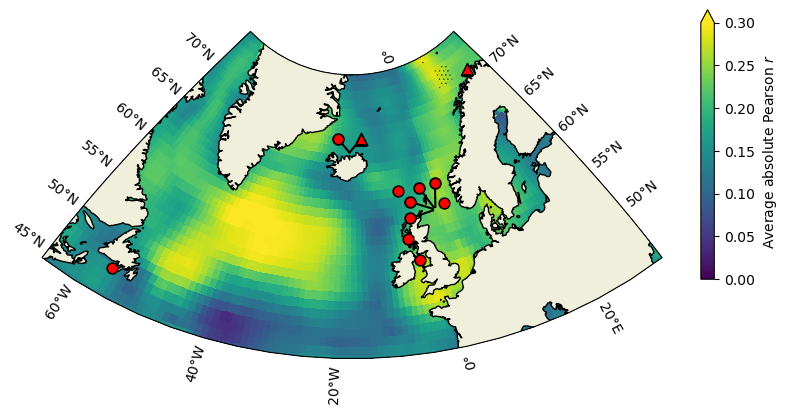

In [17]:
lons = [-65,30]
lats = [44,75]
proj = ccrs.TransverseMercator(central_longitude=lons[0]+(lons[1]-lons[0])/2,
                                   central_latitude=lats[0]+(lats[1]-lats[0])/2)
n = 20
aoi = mpath.Path(
    list(zip(np.linspace(lons[0],lons[1], n), np.full(n, lats[1]))) + \
    list(zip(np.full(n, lons[-1]), np.linspace(lats[1], lats[0], n))) + \
    list(zip(np.linspace(lons[1], lons[0], n), np.full(n, lats[0]))) + \
    list(zip(np.full(n, lons[0]), np.linspace(lats[0], lats[1], n)))
)
plt.close()
fig = plt.figure(figsize=(10,7),facecolor='white')
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
#ax2 = fig.add_subplot(1, 2, 2, projection=proj)
for ax in [ax1]:
    ax.set_boundary(aoi, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND,zorder=2)
    ax.coastlines(resolution='50m',zorder=2)
    gl = ax.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
    ax.set_extent([lons[0], lons[1], lats[0], lats[1]])
    gl.top_labels = False
    gl.right_labels = False

for i,(sr_map,ax) in enumerate(zip(['average_r'],[ax1])):
    map_avg = avg_1920_ts_corrs[sr_map].avg_corr.plot(ax=ax,transform=ccrs.PlateCarree(),
                                       vmin=0,vmax=0.3,cmap='viridis',add_colorbar=False)
    ps = avg_1920_ts_corrs['prop_sig']
    
    mpl.rcParams['hatch.linewidth'] = 0.3
    ax.contourf(ps.lon, ps.lat, ps.where(ps.num_rec>=0.5).num_rec, transform=ccrs.PlateCarree(),
           colors='none',hatches=['....'],alpha=0)
    map_avg.set_edgecolor('face')
cbar_avg = plt.colorbar(map_avg, ax=[ax1],shrink=0.5,extend='max')
cbar_avg.ax.set_ylabel(r'Average absolute Pearson $r$', fontsize=10);
    #ax1.set_title(r'$\tau$>=0.2', fontsize=14,y=1.1);

#### Plotting the bivalve records
### Grouping coordinates
for i,(rec_ids,ax) in enumerate(zip([recs_multid_pattern],[ax1])):
    biv_ews = coords.loc[rec_ids]
    coors_yr_df = biv_ews.reset_index()
    coors_yr_df.rename(columns={'index':'record'}, inplace=True)
    FG_rec = ['FG_PB_A_LCars','FG_PB_C_LCars','FG_PB_F1_LCars','FG_PB_F5_LCars','FG_JEM_PAD']
    coors_yr_df.loc[coors_yr_df[coors_yr_df.record.isin(FG_rec)].index,'Latitude'] =\
    coors_yr_df[coors_yr_df.record=='FG_PB_B_LCars']['Latitude'].iloc[0]
    coors_yr_df.loc[coors_yr_df[coors_yr_df.record.isin(FG_rec)].index,'Longitude'] =\
    coors_yr_df[coors_yr_df.record=='FG_PB_B_LCars']['Longitude'].iloc[0]
    coors_yr_gr = coors_yr_df.groupby([coors_yr_df['Latitude'].apply(lambda x: round(x*2)/2),coors_yr_df['Longitude'].apply(lambda x: round(x*2)/2)]).agg(list)
    coors_yr_gr['count'] = coors_yr_gr.record.apply(lambda x: len(x))
    unique_yr_coors = coors_yr_gr[coors_yr_gr['count']==1].record.apply(lambda x: x[0]).values
    yr_unique_coors = biv_ews.loc[unique_yr_coors]    
    markers = {'growth':'o','oxygen':'^','carbon':'d'}
    markersize = {'growth':60,'oxygen':75,'carbon':65}
    #indicator = 'kc'
    ## Records with repeated coordinates
    initial_angles = {(56.5, -6.5):-90,(59.0, 0.5):0,(59.0, 0.0):-135,(66.5, -18.0):140,(71.0, 24.0):-145,(47.0, -56.5):50}
    full_angles = {(56.5, -6.5):160,(59.0, 0.5):110,(59.0, 0.0):200,(66.5, -18.0):260,(71.0, 24.0):240,(47.0, -56.5):150}
    radii = {(56.5, -6.5):2.5,(59.0, 0.5):3,(59.0, 0.0):3,(66.5, -18.0):2,(71.0, 24.0):2.5,(47.0, -56.5):2.5}
    origin_radii = {(56.5, -6.5):0,(59.0, 0.5):0.8,(59.0, 0.0):0.3,(66.5, -18.0):0,(71.0, 24.0):0,(47.0, -56.5):0}
    ## Parameters for isotope records
    plus_radii = {(56.5, -6.5):3,(59.0, 0.5):2,(59.5, 0.5):2,(66.5, -18.0):2.5,(71.0, 24.0):2.5,(47.0, -56.5):1}
    plus_initangle = {(56.5, -6.5):0,(59.0, 0.5):-30,(59.5, 0.5):-30,(66.5, -18.0):-10,(71.0, 24.0):-7,(47.0, -56.5):0}
    if i == 1:
        selected_gr = coors_yr_gr.loc[[(56.5,-6.5),(66.5,-18.0),(71.0,24.0)]]
        uni = [r for r in yr_unique_coors.index.values if r not in ['TP_DR_d13C','Norw_MM_d18O']]
        yr_unique_coors = yr_unique_coors.loc[uni] 
    else:
        selected_gr = coors_yr_gr[coors_yr_gr['count']>1]
    for idx,row in selected_gr.iterrows():
        if i == 1 and idx in [(71.0, 24.0),(56.5,-6.5)]:
            f_rad = 0.6
        else:
            f_rad = 1
        new_coors = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]*f_rad,init_angle=initial_angles[idx],full_angle=full_angles[idx])
            
        for type_rec,marker in markers.items():
            coors_type = new_coors[new_coors.type==type_rec]
            if len(coors_type) > 0:
                ax.scatter(x=coors_type.x, y=coors_type.y, s=markersize[type_rec],linewidth=1.3, marker=marker,
                       color='red', edgecolors='k',zorder=2)
       ## Lines
        new_coors_lines = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]*f_rad-0.8,init_angle=initial_angles[idx],full_angle=full_angles[idx])
        new_coors_origin = get_new_coors_proj(row,biv_ews,proj,radius=origin_radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])        
        ax.plot([new_coors_lines.x, new_coors_origin.x], [new_coors_lines.y, new_coors_origin.y],color='k')
    ## Records with unique coordinates
    for type_rec,marker in markers.items():            
        coors_type = yr_unique_coors[yr_unique_coors.type==type_rec]
        #coors_type = coors_type.sort_values(by='kc')
        if len(coors_type) > 0:
            ax.scatter(x=coors_type.Longitude, y=coors_type.Latitude, s=markersize[type_rec],marker=marker,
                       linewidth=1.1,color='red',transform=ccrs.PlateCarree(),
                       edgecolors='k',zorder=2)

fig.savefig(f'img/EN4_avg_corr_mult_patt_rec.png',dpi=300, bbox_inches='tight')
plt.show()